#Neural Network Embedding Recommendation System
1. Load in data and clean
2. Prepare data for supervised machine learning task
3. Build the entity embedding neural network
4. Train the neural network on prediction task
5. Extract embeddings and find most similar books and wikilinks
6. Visualize the embeddings using dimension reduction techniques

## 1. Read Data & Clean
: 모든 책의 데이터는 json으로 저장되어 있음. 해당 데이터는 위키피디아의 모든 책에 대한 기사가 포함되어 있음

1-1. 데이터 불러오기

In [1]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
# jupyter notebook에서 모든 ourput 나타내기
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# import os
# print(os.listdir("./input"))

In [3]:
# utils import get_file == url -> file download
import tensorflow as tf
# from keras.utils import get_file

x = tf.keras.utils.get_file('found_books_filtered.ndjson', 'https://raw.githubusercontent.com/WillKoehrsen/wikipedia-data-science/master/data/found_books_filtered.ndjson')

import json

books = []

with open(x, 'r') as fin: # 'r' 읽기용으로 파일 열기
    # Append each line to the books
    books = [json.loads(l) for l in fin]

# Remove non-book articles
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]
print(f'Found {len(books)} books.')


58933248/58925764 [==============================] - 11s 0us/step
Found 37020 books.


1-2. 데이터 전처리
- 책에 관한 모든 페이지를 검색해 책의 제목, 기본 정보, 다른 위키피디아 페이지(위키링크)를 가리키는 링크, 외부 사이트 링크를 저장
- 추천 시스템을 만들기 위해 필요한 정보는 제목과 위키링크 두 가지입니다
- 일부 기사에는 책에대한 기사가 아닌 것들을 잡아낸다.

In [4]:
# book list 내부의 book_with_wikipedia 일부 가져오기
[book[0] for book in books_with_wikipedia][:3]



['Wikipedia:Wikipedia Signpost/2014-06-25/Recent research',
 'Wikipedia:New pages patrol/Unpatrolled articles/December 2010',
 'Wikipedia:Templates for discussion/Log/2012 September 23']

In [5]:
# 제목, 'infoboxs book'의 정보, 위키피디아 링크, 외부링크, 최종수정날짜, 기사의 문자 수
# title, information from 'infobos book' template, wikipedia links, externel links, the date of last edit, the number of characters in article
n = 21
books[n][0], books[n][1], books[n][2][:5], books[n][:5], books[n][:5], books[n][4], books[n][5]

('Limonov (novel)',
 {'name': 'Limonov',
  'author': 'Emmanuel Carrère',
  'translator': 'John Lambert',
  'country': 'France',
  'language': 'French',
  'publisher': 'P.O.L.',
  'pub_date': '2011',
  'english_pub_date': '2014',
  'pages': '488',
  'isbn': '978-2-8180-1405-9'},
 ['Emmanuel Carrère',
  'biographical novel',
  'Emmanuel Carrère',
  'Eduard Limonov',
  'Prix de la langue française'],
 ['Limonov (novel)',
  {'name': 'Limonov',
   'author': 'Emmanuel Carrère',
   'translator': 'John Lambert',
   'country': 'France',
   'language': 'French',
   'publisher': 'P.O.L.',
   'pub_date': '2011',
   'english_pub_date': '2014',
   'pages': '488',
   'isbn': '978-2-8180-1405-9'},
  ['Emmanuel Carrère',
   'biographical novel',
   'Emmanuel Carrère',
   'Eduard Limonov',
   'Prix de la langue française',
   'Prix Renaudot',
   '2011 in literature',
   'Contemporary French literature',
   'Category:2011 French novels',
   'Category:French biographies',
   'Category:Biographical novels'

In [6]:
# 책정보 정수로 변경하기 # index 
book_index = {book[0] : idx for idx, book in enumerate(books)} #enumerate : 인덱스, 원소로 이루어진 tuple로 만들어줌
index_book = {idx : book for book, idx in book_index.items()} # items() : key와 대응값 가져오기 # book_index의 대응값 'title' 가져오기

book_index['Dreaming Spies']
index_book[98]
index_book[100]


98

'Dreaming Spies'

'A Million Ways to Die in the West (novel)'

In [7]:
# Exploring Wikilinks
# chain method = 자기자신을 반환하면서 다른 함수를 지속적으로 호출할 수 있는 방법
from itertools import chain
wikilinks = list(chain(*[book[2] for book in books]))
print(f"There are {len(set(wikilinks))} unique wikilinks.") # set() 중복제거


There are 311276 unique wikilinks.


In [8]:
# 다른책에는 얼마나 많은 wiki link가 있나?
wikilinks_other_book = [link for link in wikilinks if link in book_index.keys()] #link에 key, 대응값이 있다면 wikilinks에서 link list로 뽑아 만든다
print(f"There are {len(set(wikilinks_other_book))} unique wikilinks to other books") # 중복치 제거 길이값

There are 17032 unique wikilinks to other books


In [9]:
# 가장 많이 연결된 기사 찾기
# items 항목 수가 카운트된 dictionary를 반환하는 함수를 만든다.
# collections module : count(개수세기), OrderedDict

from collections import Counter, OrderedDict

def count_items(l):
  # Return ordered dictionary of counts of objects in `l`
  # create a count object
  counts = Counter(l)

  # sort by highest count first and place in orderd dictionary
  # sort(key = (key인자에 함수를 넘겨주면 우선순위가 정해진다))
  counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)  # x[1] 우선순위 숫자로 변경, reverse = 높은 숫자부터
  counts = OrderedDict(counts) # 데이터 순서 설정(key, val)

  return counts


In [10]:
# Find set of wikilinks from each book and convert to a flattend last
# 각각 책에서 wikilinks 설정을 찾고 1차원으로 변경하기

# list(chain(*(set ~~))) = ????

unique_wikilinks = list(chain(*[list(set(book[2])) for book in books])) # books의 중복치를 제거한 wikilinks 값

wikilink_counts = count_items(unique_wikilinks) # 가장 많이 사용된 wikilinks의 unique_counts 상위 10개 불러오기
list(wikilink_counts.items())[:10]

[('Hardcover', 7489),
 ('Paperback', 7311),
 ('Wikipedia:WikiProject Books', 6043),
 ('Wikipedia:WikiProject Novels', 6015),
 ('English language', 4185),
 ('United States', 3060),
 ('Science fiction', 3030),
 ('The New York Times', 2727),
 ('science fiction', 2502),
 ('novel', 1979)]

In [11]:
# 대문자 -> 소문자로 변경하기
wikilinks = [link.lower() for link in unique_wikilinks] # lower() 대문자 -> 소문자 : 동일링크 : paperback, Paperback, PAPERBACK 등 링크 통합
print(f"There are {len(set(wikilinks))} unique wikilinks.")

wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:10]

There are 297624 unique wikilinks.


[('paperback', 8740),
 ('hardcover', 8648),
 ('wikipedia:wikiproject books', 6043),
 ('wikipedia:wikiproject novels', 6016),
 ('science fiction', 5665),
 ('english language', 4248),
 ('united states', 3063),
 ('novel', 2983),
 ('the new york times', 2742),
 ('fantasy', 2003)]

Text(0.5, 1.0, 'wikilink_counts_top10')

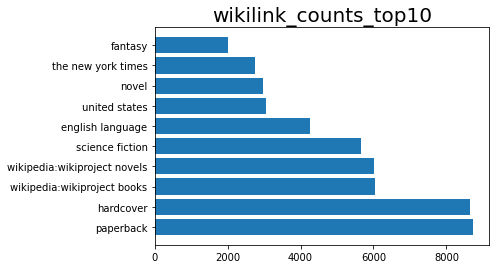

In [12]:
# 데이터 시각화
# wikilink_ count_top10

# for i in range(11):
#   wikilink_counts_top = list(wikilink_counts.items())[i]
import matplotlib.pyplot as plt
wikilink_counts_top = list(wikilink_counts.items())[:10]

index = [8740, 8648, 6043, 6016, 5665, 4248, 3063, 2983, 2742, 2003]
columns = ['paperback', 'hardcover', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels', 'science fiction', 'english language', 'united states', 'novel', 'the new york times', 'fantasy']
bar_plot = plt.barh(columns, index)

# def autolabel(rects):
#     for idx,rect in enumerate(bar_plot):
#         height = rect.get_height()
#         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,index[idx],
#                 ha='center', va='bottom', rotation=0)
# autolabel(bar_plot)
plt.title('wikilink_counts_top10', fontsize=20)
plt.xlabel = ('unique wikilinks')
plt.ylabel = ('counts')
plt.show()

In [13]:
## wikilinks unique값 구하기
# 가장 많은 wikilink 제거하기
# paperback, hardcover, wikipedia:wikiproject books, wikipedia:wikiproject novels
# 이유 
# 1) paperback(얇은 가벼운 재질의 책), hardcover(딱딱한 겉표지), hardback(=hardcover), e-book(책의 종류, 내용 X) -> 도서정보와 관련이 없음
# 2) wikiproject books, wikiproject novels (wikiproject = 단순 책에 대한 정보 정리, 기사 X, 콘텐츠 기반 X)

to_remove = ['hardcover', 'paperback', 'hardback', 'e-book', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels'] 

for t in to_remove:
    wikilinks.remove(t)
    _ = wikilink_counts.pop(t) # ????? #pop(t) t가 들어간 to_move의 카테고리들을 제거해라

In [14]:
# 4번 이상 나온 wikilinks를 사용한다.

links = [t[0] for t in wikilink_counts.items() if t[1] >= 4] # ?????
type(links)


list

In [15]:
# wikipedia에서 다른 책과 가장 많이 연결된 도서 top10
# 각 책에대한 book wikilinks 찾기
unique_wikilinks_books = list(chain(*[list(set(link for link in book[2] if link in book_index.keys())) for book in books])) # * 모든것 : chain(10) -> 10 11 12 13 14 이어붙이기 

# 다른책에서 링크된 책의 숫자
wikilinks_book_counts = count_items(unique_wikilinks_books)
list(wikilinks_book_counts.items())[:10]



[('The Encyclopedia of Science Fiction', 127),
 ('The Discontinuity Guide', 104),
 ('The Encyclopedia of Fantasy', 63),
 ('Dracula', 55),
 ('Encyclopædia Britannica', 51),
 ('Nineteen Eighty-Four', 51),
 ('Don Quixote', 49),
 ('The Wonderful Wizard of Oz', 49),
 ("Alice's Adventures in Wonderland", 47),
 ('Jane Eyre', 39)]

Text(0.5, 1.0, 'Most linked to books by Wikipedia books')

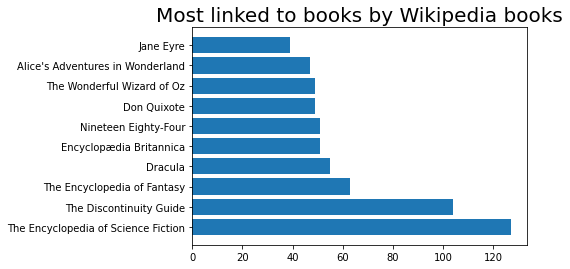

In [16]:
index = [127, 104, 63, 55, 51, 51, 49, 49, 47, 39]
columns = ['The Encyclopedia of Science Fiction', 'The Discontinuity Guide', 'The Encyclopedia of Fantasy', 'Dracula', 'Encyclopædia Britannica', 'Nineteen Eighty-Four', 'Don Quixote', 'The Wonderful Wizard of Oz', "Alice's Adventures in Wonderland", 'Jane Eyre']
bar_plot = plt.barh(columns, index)

plt.title('Most linked to books by Wikipedia books', fontsize=20)
plt.xlabel = ('unique wikilinks')
plt.ylabel = ('linked counts')
plt.show()

In [17]:
# 데이터 전처리 결과
print(f'Found {len(books)} books.')
print(f'Found {len(links)} links.')

Found 37020 books.
Found 41758 links.


##추가 전처리 작업

In [18]:
# 잠재적인 추가제거 작업
# 데이터 전처리를 추가적으로 진행하고 싶다면 수행
for book in books:
    if 'The New York Times' in book[2] and 'New York Times' in book[2]:
        print(book[0], book[2])
        break




The Big Picture: Who Killed Hollywood? and Other Essays ['Wikipedia:WikiProject Novels', 'Wikipedia:WikiProject Books', 'William Goldman', 'United States', 'English language', 'William Goldman', 'Michael Sragow', 'Good Will Hunting', 'Robin Williams', 'Matt Damon', 'The New York Times', 'The New York Times Company', 'New York Times', 'Category:Cinema of the United States', 'Category:Film production', 'Category:2000 books', 'Category:Books about films', 'Category:Books by William Goldman', 'Category:Show business memoirs']


In [19]:
wikilink_counts.get('the new york times')

wikilink_counts.get('new york times')

2742

996

In [20]:
# Wikilinks to Index
# book 데이터를 정수로 바꾸어주었듯이, Wikilinks도 정수로 바꿔준다
link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

link_index['the economist']
index_link[300]
print(f'There are {len(link_index)} wikilinks that will be used.')


300

'the economist'

There are 41758 wikilinks that will be used.


######################################################################

#2.Superised Machine Learning Task
임베딩 신경망을 훈련하기 위한 머신 러닝 작업을 개발하기

##  Build a Training Set
지도학습 :
(book, links)의 값이 주어지면 데이터에 있는 정보인지 예측하는 학습모델을 만든다.
trainset을 만들기 위해 모든책의 title, wikilink는 (title, wikilink)튜플 형태로 저장한다. 


In [21]:
# # 책 이름과 책의 고유 인덱스 index 맵핑
# type(books)
# book_index = {book[0]: idx for idx, book in enumerate(books)}
# print(book_index)

# # 링크와 링크 고유 인덱스 mapping
# # links = tuple(links)
# type(links)
# link_index = {book[2]: idx for idx, book in enumerate(links)}
# print(link_index)

In [22]:
# pairs = []

# # 각각 책이 나오도록 반복
# for book in books:

#     title = book[0]
#     book_links = book[2]
#     # 책에 관한 글에 있는 wikilinks 들을 반복
#     for link in book_links:
#         # 책의 인덱스와 링크 페어 저장
#         pairs.extend(book_index[title], link_index[link])

In [23]:
pairs = [] # pairs 빈 list 생성

# 각 책에대한 반복 수행
for book in books:
    # 각 책에대한 링크를 반복 수행
    # 770,000개의 예시 추가
    # 예시 각 title마다 link가 들어간 pairs만들기 (2, 616), (2, 2914) -> 77만개
    pairs.extend((book_index[book[0]], link_index[link.lower()]) for link in book[2] if link.lower() in links)

# 모델을 훈련시키기 위한 777,000개의 예시를 보여준다.
len(pairs), len(links), len(books)
pairs[5000]

(772798, 41758, 37020)

(321, 232)

In [39]:
# 모델을 훈련시키기 위한 777,000개의 예시를 보여준다.
pairs[5000]

pairs[50]
pairs[51]
pairs[52]
pairs[53]

(321, 232)

(2, 616)

(2, 2914)

(2, 4748)

(2, 2305)

In [25]:
# 777,000여개의 데이터 확인하기
# 5000번대
index_book[pairs[5000][0]], index_link[pairs[5000][1]]

# 1200번대
index_book[pairs[1200][0]], index_link[pairs[1200][1]]

('Slaves in the Family', 'category:american biographies')

('De Materia Medica', 'lyon')

In [26]:
# 링크, 책 무작위 샘플링 후 확인 -> 맞지 않는 예시 만들기
pairs_set = set(pairs)

# 가장 자주 나타나는 (title, link)
x = Counter(pairs)
sorted(x.items(), key = lambda x: x[1], reverse = True)[:10]

[((13337, 31110), 85),
 ((31899, 65), 77),
 ((25899, 8850), 61),
 ((1851, 2629), 57),
 ((25899, 30465), 53),
 ((1851, 4634), 33),
 ((26736, 61), 32),
 ((13338, 31110), 31),
 ((30581, 780), 29),
 ((35030, 1904), 29)]

## Train/Test set에 관한 참고사항
validation set or testset을 만들지 않는데, accuracy를 측정하는 모델이 아니라 embedding model을 생성하는 게 주된 목표이다.

model train 후, 새로운 데이터에 대한 model test가 없으므로 과적합을 방지할 필요가 없다. 


In [27]:
# 데이터셋 positive, negative 생성기 만들기
# 다시 복습 # 모르겠음 ㅠㅠ

import numpy as np
import random
random.seed(100)

def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0, classification = False):
  # batch를 저장할 numpy 배열 준비하기
  batch_size = n_positive * (1 + negative_ratio)
  batch = np.zeros((batch_size, 3)) # shape = batch_size * 3

  # 라벨 조정하기
  if classification:
    neg_label = 0
  else:
    neg_label = -1

  # 생성기 만들기
  while True:
    # 랜덤 positive 예시 선택
    for idx, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
      batch[idx, :] = (book_id, link_id, 1)

    # idx = 1씩 증가
    idx += 1

    # batchsize가 찰때까지, negative examples 추가
    while idx < batch_size:

      # 랜덤선택
      random_book = random.randrange(len(books))
      random_link = random.randrange(len(links))

      # positive sample이 아니라는 걸 체크
      if (random_book, random_link) not in pairs_set:

        # 배치에 negative_index  추가하기 
        batch[idx, :] = (random_book, random_link, neg_label)
        idx += 1

      
    # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]


In [28]:
# 새로운 batch 얻기
next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

({'book': array([    0.,  6895., 22162.,     0., 29814.,     0.]),
  'link': array([    0.,   260.,  5588.,     0., 11452.,     0.])},
 array([ 0.,  1.,  1.,  0., -1.,  0.]))

In [29]:
# train pairs 예시 확인하기
a, b = next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

for label, book_idx, link_idx in zip(b, a['book'], a['link']):
  print(f'Book: {index_book[book_idx]:30} Link : {index_link[link_idx]:40} Label : {label}')

# x, y = next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

# for label, b_idx, l_idx in zip(y, x['book'], x['link']):
#     print(f'Book: {index_book[b_idx]:30} Link: {index_link[l_idx]:40} Label: {label}') 

Book: The Mirror of Simple Souls     Link : christian mysticism                      Label : 1.0
Book: Freud: His Life and His Mind   Link : science fiction                          Label : 0.0
Book: The Early Fears                Link : later jin (five dynasties)               Label : -1.0
Book: Freud: His Life and His Mind   Link : science fiction                          Label : 0.0
Book: Freud: His Life and His Mind   Link : science fiction                          Label : 0.0
Book: The Albino's Treasure          Link : sexton blake                             Label : 1.0


#3.Neural Network Embedding Model
###5 layers 
 1) input layer : book, link에 대한 병렬 입력 \
 2) Embedding : book, link를 위한 병렬 50개 Embedding \
 3) Dot : 내적(Dot product)를 계산해 Embedding 합치기 \
 4) Reshape : Embedding shape를 단일 숫자로 형성 \
 5) Dense : sigmoid activation을 이용한 출력 

In [32]:
from tensorflow.keras.layers import Input, Embedding, Dot, Reshape, Dense
from tensorflow.keras.models import Model

In [33]:
def book_embedding_model(embedding_size=50, classification = False):

  # """Model to embed books and wikilinks using the functional API.
  #    \Trained to discern if a link is present in a article"""

    # 1차원 입력
    book = Input(name='book', shape=[1])
    link = Input(name='link', shape=[1])

    # 책 Embedding(None, 1, 50)
    book_embedding = Embedding(name = 'book_embedding',
                               input_dim = len(book_index),
                               output_dim = embedding_size)(book)

    # link Embedding(None, 1, 50)
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link_index),
                               output_dim = embedding_size)(link)

    # 내적으로 book&link embedding 1개의 Embedding으로 변형
    # shape will be(None, 1, 1)
    # Dot(name, normalize(정규화), axes(샘플 간 내적계산))
    merged = Dot(name = 'dot_product', normalize = True, axes=2)([book_embedding, link_embedding])

    # Reshape to be single Number(shape will be(None, 1))
    merged = Reshape(target_shape = [1])(merged)

    # if classifcation, add extra layers and loss function is binary crossentroy
    if classification:
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [book, link], outputs = merged)
        model.comfile(optimizer = 'Adam', loss = 'binary_crossentrypy', metrics = ['acccuracy'])

      # Otherwise loss function is mean squared error
    else:
      # model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer='adam', loss='mse')

    return model

# Instantitate model and show parameters
model = book_embedding_model()
model.summary()



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
link (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 50)        1851000     book[0][0]                       
_____________________________________________________________________________________________

#4. TRAIN MODEL


In [41]:
n_positive = 1024

gen = generate_batch(pairs, n_positive, negative_ratio=2)

# Train
# steps_per_epoch = 1epoch마다 사용할 batch_size를 정의함
# verbose(상세정보) 보통 0, 자세히 1, 함축정보 2
model.fit_generator(gen, epochs = 15, steps_per_epoch = len(pairs) // n_positive, verbose=2)

Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
754/754 - 30s - loss: 0.0115
Epoch 2/15
754/754 - 30s - loss: 0.0078
Epoch 3/15
754/754 - 31s - loss: 0.0122
Epoch 4/15
754/754 - 30s - loss: 0.0113
Epoch 5/15
754/754 - 31s - loss: 0.0088
Epoch 6/15
754/754 - 30s - loss: 0.0147
Epoch 7/15
754/754 - 31s - loss: 0.0132
Epoch 8/15
754/754 - 30s - loss: 0.0124
Epoch 9/15
754/754 - 30s - loss: 0.0165
Epoch 10/15
754/754 - 30s - loss: 0.0126
Epoch 11/15
754/754 - 30s - loss: 0.0142
Epoch 12/15
754/754 - 31s - loss: 0.0127
Epoch 13/15
754/754 - 30s - loss: 0.0117
Epoch 14/15


KeyboardInterrupt: 